    You need mnemo (github.com/perarnau/mnemo.git) to be installed for this notebook to work.
    Alternatively, you can use the nix-shell provided in this repo.
    
    You can also use a LIBMNEMO_SO environmnent variable is also supported, as long as the mnemo python package is in your PYTHONPATH.

In [1]:
import mnemo
import main
import numpy as np
import cProfile

In [2]:
# make it a class so that we can do cross-iteration tracing
class Reuse:
    def __init__(self):
        self.trace = mnemo.ReuseDM(0)
        self.distances = []
        
    def reset(self):
        self.trace.reset()
        self.distance = []
        
    def add(self, h):
        d = self.trace.add(h)
        self.distances.append(d)
        
    def view1d(self):
        return np.copy(self.distances)

In [3]:
class TracedHamiltonian(main.Hamiltonian):
    def __init__(self, reuse, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trace = reuse
        
    def hash_record(self,i,j,k,l):
        p = min(i,k)
        r = max(i,k)
        t = p + (r*(r-1)//2)
        q = min(j,l)
        s = max(j,l)
        u = q + (s*(s-1)//2)
        v = min(t,u)
        w = max(t,u)
        return v + (w*(w-1)//2)
        
    def H_two_e(self, i, j, k, l):
        h = self.hash_record(i,j,k,l)
        self.trace.add(h)
        return super().H_two_e(i,j,k,l)

In [4]:
fci_path = 'f2_631g.FCIDUMP'
wf_path = 'f2_631g.30det.wf'
N_ord, E0, d_one_e_integral, d_two_e_integral = main.load_integrals(f"data/{fci_path}")
psi_coef, psi_det = main.load_wf(f"data/{wf_path}")
reuse = Reuse()
lewis = TracedHamiltonian(reuse, d_one_e_integral, d_two_e_integral, E0)

In [5]:
cProfile.run("main.Powerplant(lewis, psi_det).E(psi_coef)")

         108653 function calls in 0.066 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(einsum)
     7360    0.005    0.000    0.021    0.000 <ipython-input-2-1c51c7345b32>:11(add)
     7360    0.009    0.000    0.052    0.000 <ipython-input-3-8d3c46a98a56>:17(H_two_e)
     7360    0.009    0.000    0.018    0.000 <ipython-input-3-8d3c46a98a56>:6(hash_record)
        1    0.000    0.000    0.066    0.066 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 einsumfunc.py:1004(einsum)
        6    0.000    0.000    0.000    0.000 einsumfunc.py:995(_einsum_dispatcher)
      552    0.000    0.000    0.000    0.000 main.py:307(H_one_e)
     7360    0.003    0.000    0.003    0.000 main.py:313(H_two_e)
      408    0.003    0.000    0.003    0.000 main.py:321(get_phase_idx_single_exc)
     6372    0.000    0.000    0.000    0.000 main.py:

In [6]:
print(lewis.trace.view1d())

[ -1  -1  -1 ... 119  96 119]


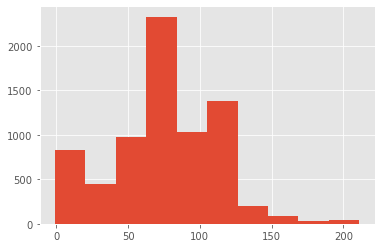

In [8]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.hist(lewis.trace.view1d())
plt.show()

In [48]:
fci_path='f2_631g.FCIDUMP'
wf_path='f2_631g.1det.wf'
E_ref =  -198.73029308564543
N_ord, E0, d_one_e_integral, d_two_e_integral = main.load_integrals(f"data/{fci_path}")
psi_coef, psi_det = main.load_wf(f"data/{wf_path}")
reuse = Reuse()
lewis = TracedHamiltonian(reuse, d_one_e_integral, d_two_e_integral, E0)

In [49]:
from main import selection_step

In [50]:
sel_hists = []
n = 5
for i in range(4):
    lewis.trace.reset()
    cProfile.run("_, psi_coef, psi_det = selection_step(lewis, N_ord, psi_coef, psi_det, n)")
    sel_hists.append(lewis.trace.view1d())
    n = n*2

         27614682 function calls in 10.276 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.049    0.049 <__array_function__ internals>:2(argpartition)
        1    0.000    0.000    0.003    0.003 <__array_function__ internals>:2(eigh)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(einsum)
  2113699    0.976    0.000    3.050    0.000 <ipython-input-42-1c51c7345b32>:11(add)
  2113699    1.786    0.000    9.006    0.000 <ipython-input-43-8d3c46a98a56>:17(H_two_e)
  2113699    1.688    0.000    3.654    0.000 <ipython-input-43-8d3c46a98a56>:6(hash_record)
        1    0.001    0.001   10.276   10.276 <string>:1(<module>)
     9315    0.002    0.000    0.005    0.000 <string>:1(__new__)
        1    0.000    0.000    0.000    0.000 _asarray.py:16(asarray)
        3    0.000    0.000    0.000    0.000 einsumfunc.py:1004(einsum)
       17    0.000    0.000    0.000

         144768100 function calls in 54.425 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(argpartition)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(eigh)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(einsum)
 10953410    5.083    0.000   16.011    0.000 <ipython-input-42-1c51c7345b32>:11(add)
 10953410    9.313    0.000   47.108    0.000 <ipython-input-43-8d3c46a98a56>:17(H_two_e)
 10953410    8.812    0.000   19.156    0.000 <ipython-input-43-8d3c46a98a56>:6(hash_record)
        1    0.005    0.005   54.424   54.424 <string>:1(<module>)
    55890    0.009    0.000    0.071    0.000 <string>:1(__new__)
        1    0.000    0.000    0.000    0.000 _asarray.py:16(asarray)
        6    0.000    0.000    0.000    0.000 cycler.py:227(<genexpr>)
        3    0.000    0.000    0.000 

         805262608 function calls in 335.482 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.003    0.003 <__array_function__ internals>:2(argpartition)
        1    0.000    0.000    0.051    0.051 <__array_function__ internals>:2(eigh)
        3    0.000    0.000    0.006    0.002 <__array_function__ internals>:2(einsum)
 57388246   28.213    0.000   90.503    0.000 <ipython-input-42-1c51c7345b32>:11(add)
 57388246   51.938    0.000  264.268    0.000 <ipython-input-43-8d3c46a98a56>:17(H_two_e)
 57388246   49.147    0.000  105.969    0.000 <ipython-input-43-8d3c46a98a56>:6(hash_record)
        1    0.048    0.048  335.482  335.482 <string>:1(<module>)
   335340    0.046    0.000    0.103    0.000 <string>:1(__new__)
        1    0.000    0.000    0.000    0.000 _asarray.py:16(asarray)
        3    0.000    0.000    0.006    0.002 einsumfunc.py:1004(einsum)
       17    0.000    0.000    0.0

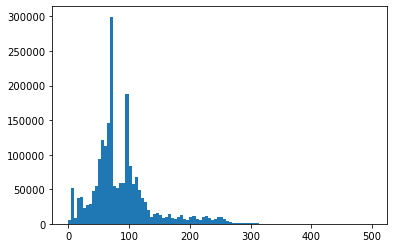

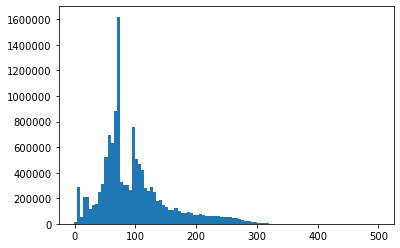

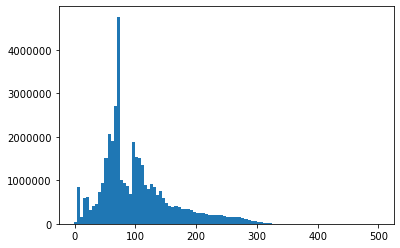

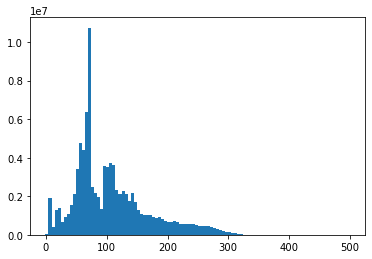

In [51]:
for h in sel_hists:
    plt.hist(h, bins=100, range=(-1,500))
    plt.show()

## Analysis with Checkpoints

Reworking the analysis with the new checkpoints, looking at the two types of 4d access patterns

In [9]:
# checkpoints, and the symmetric part
fci_path='c2_eq_hf_dz.fcidump*'
N_ord, E0, d_one_e_integral, d_two_e_integral = main.load_integrals(f"data/{fci_path}")
reuse = Reuse()

check_sym_hists = []
for i in range(1, 11):
    wf_path=f"c2_eq_hf_dz_{i}.*.wf*"
    psi_coef, psi_det = main.load_wf(f"data/{wf_path}")
    reuse.reset()
    lewis = TracedHamiltonian(reuse,d_one_e_integral, d_two_e_integral, E0)
    main.Powerplant(lewis, psi_det).E(psi_coef)
    check_sym_hists.append(lewis.trace.view1d())

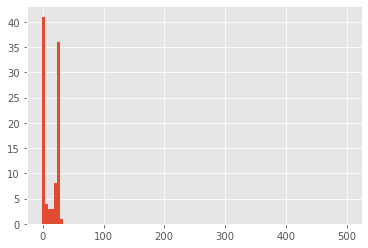

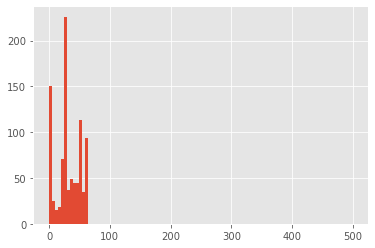

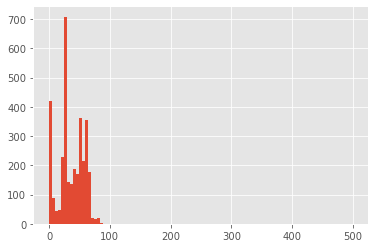

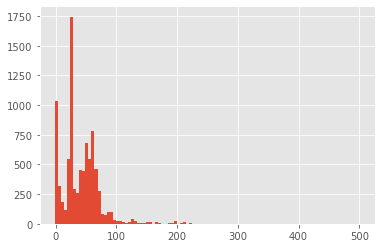

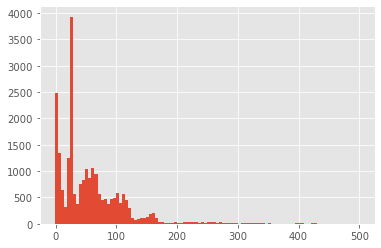

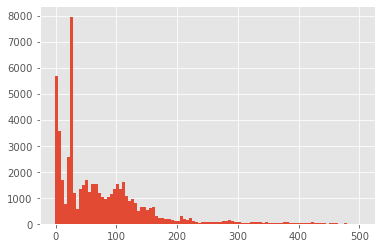

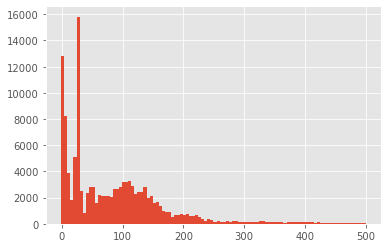

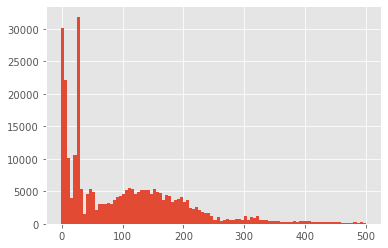

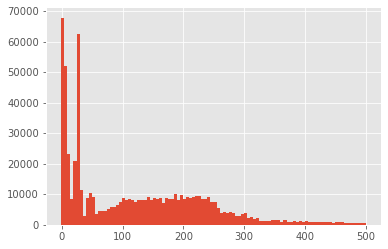

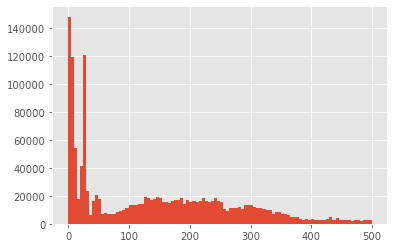

In [10]:
for h in check_sym_hists:
    plt.hist(h, bins=100, range=(-1,500))
    plt.show()

In [15]:
# checkpoints, and the external part
fci_path='c2_eq_hf_dz.fcidump*'
N_ord, E0, d_one_e_integral, d_two_e_integral = main.load_integrals(f"data/{fci_path}")
reuse = Reuse()

check_ext_hists = []
for i in range(1, 5):
    wf_path=f"c2_eq_hf_dz_{i}.*.wf*"
    psi_coef, psi_det = main.load_wf(f"data/{wf_path}")
    reuse.reset()
    lewis = TracedHamiltonian(reuse,d_one_e_integral, d_two_e_integral, E0)
    psi_external = main.Excitation(N_ord).gen_all_connected_determinant_from_psi(psi_det)
    h = lewis.H(psi_det, psi_external)
    check_ext_hists.append(lewis.trace.view1d())

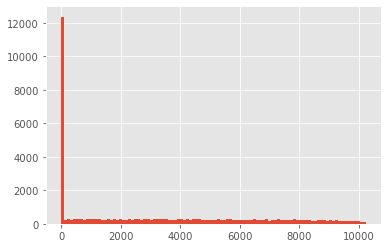

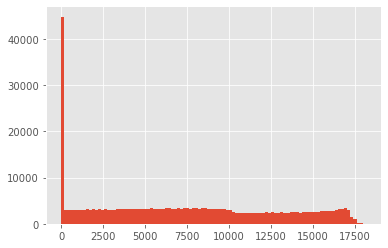

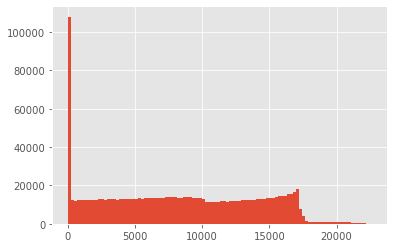

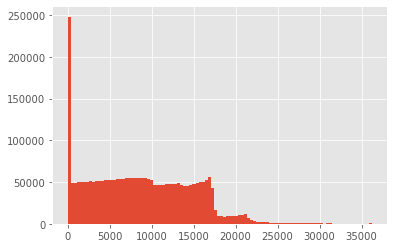

In [16]:
for h in check_ext_hists:
    plt.hist(h, bins=100)
    plt.show()

In [ ]:
|